**Step 1: Install And Import Libraries**

In [ ]:
#Sentiment140 dataset with 1.6 million tweets

In [ ]:
!pip install gensim --upgrade
!pip install keras --upgrade
!pip install pandas --upgrade
!pip install tensorflow --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 24.1 MB 1.3 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 4.8 MB/s 
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0+zzzcolab20220506162203 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
tensorflow 2.8.0+zzzcolab20220506162203 requires keras<2.9,>=2.8.0rc0, but you have keras 2.9.0 

In [ ]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk - Natural Language Toolkit
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

# Word2vec
import gensim
#from gensim.test.utils import common_texts
from gensim.models import Word2Vec

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

**Step 2: Setting Parameter**

In [ ]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 150
W2V_WINDOW = 7
W2V_EPOCH = 16
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS =(0.4 , 0.7)  

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

**Step 3: Import the Dataset**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/data mining/new dataset/training.1600000.processed.noemoticon.csv'
df = pd.read_csv(path, encoding =DATASET_ENCODING , names=DATASET_COLUMNS)

**Step 4: Explore the Data**

**Step 4.1: Get an Overview**

In [ ]:
print("Dataset size:", len(df))

Dataset size: 1600000


In [ ]:
df.head(5)

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [ ]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

CPU times: user 430 ms, sys: 793 µs, total: 431 ms
Wall time: 433 ms


**Step 4.2: Check if the Data Is Balanced**

Text(0.5, 1.0, 'Dataset labels distribuition')

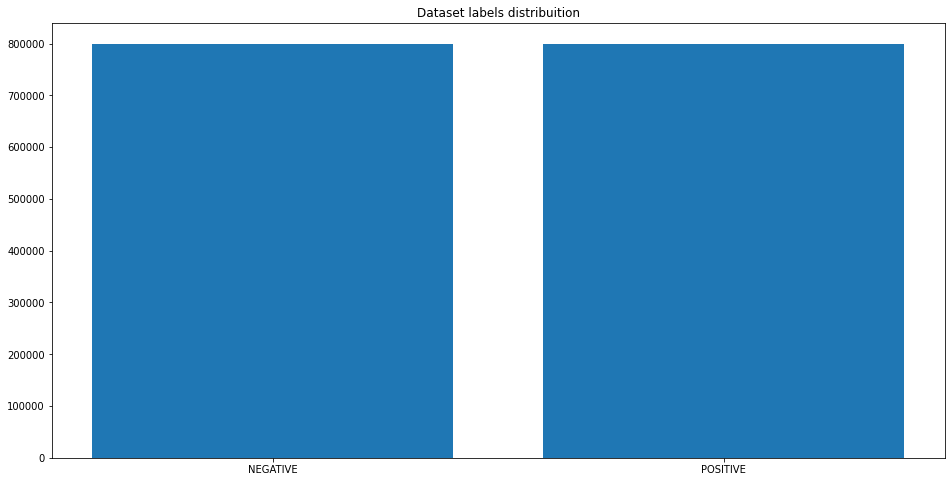

In [ ]:
target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

**Step 5: Pre-Processing Dataset**

In [ ]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [ ]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [ ]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

CPU times: user 53.1 s, sys: 201 ms, total: 53.3 s
Wall time: 53.3 s


 **Step 6: Modeling**

**Step 6.1:Split train and test**

In [ ]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 1280000
TEST size: 320000


**Step 6.2: Build, Train and Evaluate a Word2Vec**

In [ ]:
%%time
documents = [_text.split() for _text in df_train.text] 

CPU times: user 2.82 s, sys: 325 ms, total: 3.15 s
Wall time: 3.14 s


In [ ]:
w2v_model = gensim.models.word2vec.Word2Vec(vector_size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

2022-05-30 10:20:30,139 : INFO : Word2Vec lifecycle event {'params': 'Word2Vec<vocab=0, vector_size=150, alpha=0.025>', 'datetime': '2022-05-30T10:20:30.139375', 'gensim': '4.2.0', 'python': '3.7.13 (default, Apr 24 2022, 01:04:09) \n[GCC 7.5.0]', 'platform': 'Linux-5.4.188+-x86_64-with-Ubuntu-18.04-bionic', 'event': 'created'}


In [ ]:
w2v_model.build_vocab(documents)

2022-05-30 10:20:30,155 : INFO : collecting all words and their counts
2022-05-30 10:20:30,157 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2022-05-30 10:20:30,191 : INFO : PROGRESS: at sentence #10000, processed 72565 words, keeping 14005 word types
2022-05-30 10:20:30,214 : INFO : PROGRESS: at sentence #20000, processed 144393 words, keeping 21587 word types
2022-05-30 10:20:30,235 : INFO : PROGRESS: at sentence #30000, processed 215826 words, keeping 27541 word types
2022-05-30 10:20:30,257 : INFO : PROGRESS: at sentence #40000, processed 288271 words, keeping 32764 word types
2022-05-30 10:20:30,278 : INFO : PROGRESS: at sentence #50000, processed 359772 words, keeping 37587 word types
2022-05-30 10:20:30,300 : INFO : PROGRESS: at sentence #60000, processed 431431 words, keeping 42198 word types
2022-05-30 10:20:30,323 : INFO : PROGRESS: at sentence #70000, processed 503103 words, keeping 46458 word types
2022-05-30 10:20:30,344 : INFO : PROGRESS: at s

In [ ]:
words = w2v_model.wv.key_to_index.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 30369


In [ ]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

2022-05-30 10:20:34,045 : INFO : Word2Vec lifecycle event {'msg': 'training model with 8 workers on 30369 vocabulary and 150 features, using sg=0 hs=0 sample=0.001 negative=5 window=7 shrink_windows=True', 'datetime': '2022-05-30T10:20:34.045895', 'gensim': '4.2.0', 'python': '3.7.13 (default, Apr 24 2022, 01:04:09) \n[GCC 7.5.0]', 'platform': 'Linux-5.4.188+-x86_64-with-Ubuntu-18.04-bionic', 'event': 'train'}
2022-05-30 10:20:35,066 : INFO : EPOCH 0 - PROGRESS: at 5.11% examples, 416350 words/s, in_qsize 15, out_qsize 0
2022-05-30 10:20:36,075 : INFO : EPOCH 0 - PROGRESS: at 10.97% examples, 446924 words/s, in_qsize 16, out_qsize 1
2022-05-30 10:20:37,109 : INFO : EPOCH 0 - PROGRESS: at 17.24% examples, 464720 words/s, in_qsize 16, out_qsize 0
2022-05-30 10:20:38,117 : INFO : EPOCH 0 - PROGRESS: at 22.76% examples, 461334 words/s, in_qsize 16, out_qsize 0
2022-05-30 10:20:39,164 : INFO : EPOCH 0 - PROGRESS: at 29.05% examples, 467966 words/s, in_qsize 15, out_qsize 0
2022-05-30 10:20:

CPU times: user 8min 47s, sys: 2.84 s, total: 8min 50s
Wall time: 4min 47s


(131564747, 147635264)

In [ ]:
w2v_model.wv.most_similar("love")

[('adore', 0.6372788548469543),
 ('luv', 0.617905855178833),
 ('loves', 0.6104198694229126),
 ('loved', 0.5789036154747009),
 ('looove', 0.5575966238975525),
 ('loooove', 0.5275892615318298),
 ('loveee', 0.5248758792877197),
 ('amazing', 0.5208113789558411),
 ('loove', 0.5087915062904358),
 ('lovee', 0.5042241215705872)]

In [ ]:
w2v_model.wv.most_similar("hate")

[('hates', 0.6300157308578491),
 ('dislike', 0.6080014705657959),
 ('sucks', 0.5865602493286133),
 ('suck', 0.5803241729736328),
 ('despise', 0.5426598191261292),
 ('stupid', 0.5395144820213318),
 ('h8', 0.5340875387191772),
 ('hating', 0.5300694704055786),
 ('ugh', 0.4680060148239136),
 ('annoying', 0.4613381326198578)]

**Step 6.3: Preparing data for neural network(LSTM)**

**Step 6.3.1:Tokenize word**

In [ ]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 290419
CPU times: user 15.9 s, sys: 194 ms, total: 16.1 s
Wall time: 16 s


In [ ]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

CPU times: user 21.5 s, sys: 1.21 s, total: 22.7 s
Wall time: 22.7 s


**Step 6.3.2:Label Encoder**

In [ ]:
labels = df_train.target.unique().tolist()
labels.append(NEUTRAL)
labels

['POSITIVE', 'NEGATIVE', 'NEUTRAL']

In [ ]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (1280000, 1)
y_test (320000, 1)


In [ ]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (1280000, 300)
y_train (1280000, 1)

x_test (320000, 300)
y_test (320000, 1)


In [ ]:
y_train[:10]

array([[1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]])

**Step 6.3.3:Create Embedding layer**

In [ ]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word] 
print(embedding_matrix.shape)

(290419, 150)


In [ ]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

**Step 6.4:  Build Neural Network Model (LSTM)**

**Step 6.4.1: Initial Neural Network Layer**

In [ ]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

2022-05-30 10:26:03,782 : WARNING : Layer lstm will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 150)          43562850  
                                                                 
 dropout (Dropout)           (None, 300, 150)          0         
                                                                 
 lstm (LSTM)                 (None, 100)               100400    
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 43,663,351
Trainable params: 100,501
Non-trainable params: 43,562,850
_________________________________________________________________


In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

**Step 6.4.2: Train Neural Network Model**

In [ ]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

In [ ]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/8
1125/1125 [==============================] - 555s 490ms/step - loss: 0.5145 - accuracy: 0.7426 - val_loss: 0.4706 - val_accuracy: 0.7751 - lr: 0.0010
Epoch 2/8
1125/1125 [==============================] - 548s 487ms/step - loss: 0.4903 - accuracy: 0.7596 - val_loss: 0.4618 - val_accuracy: 0.7805 - lr: 0.0010
Epoch 3/8
1125/1125 [==============================] - 544s 484ms/step - loss: 0.4836 - accuracy: 0.7639 - val_loss: 0.4597 - val_accuracy: 0.7824 - lr: 0.0010
Epoch 4/8
1125/1125 [==============================] - 532s 473ms/step - loss: 0.4803 - accuracy: 0.7661 - val_loss: 0.4568 - val_accuracy: 0.7839 - lr: 0.0010
Epoch 5/8
1125/1125 [==============================] - 532s 473ms/step - loss: 0.4782 - accuracy: 0.7678 - val_loss: 0.4543 - val_accuracy: 0.7850 - lr: 0.0010
Epoch 6/8
1125/1125 [==============================] - 529s 471ms/step - loss: 0.4760 - accuracy: 0.7689 - val_loss: 0.4536 - val_accuracy: 0.7856 - lr: 0.0010
Epoch 7/8
1125/1125 [===================

**Step 6.4.3: Evaluate Neural Network Model**

In [ ]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

313/313 [==============================] - 28s 88ms/step - loss: 0.4507 - accuracy: 0.7874

ACCURACY: 0.7874187231063843
LOSS: 0.45073413848876953
CPU times: user 27 s, sys: 224 ms, total: 27.2 s
Wall time: 41.3 s


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

**Step 6.4.4: Predict Neural Network Model**

In [ ]:
def decode_sentiment(score, include_neutral=True): 
    if include_neutral:           
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:   
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [ ]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [ ]:
predict("I love the music")

1/1 [==============================] - 0s 301ms/step


{'elapsed_time': 0.34143972396850586,
 'label': 'POSITIVE',
 'score': 0.9745453000068665}

In [ ]:
predict("I hate the rain")

1/1 [==============================] - 0s 78ms/step


{'elapsed_time': 0.18493866920471191,
 'label': 'NEGATIVE',
 'score': 0.005832131020724773}

In [ ]:
predict("i don't know what i'm doing")

1/1 [==============================] - 0s 81ms/step


{'elapsed_time': 0.11629152297973633,
 'label': 'NEGATIVE',
 'score': 0.3966516852378845}

In [ ]:
predict("I feel the same")

1/1 [==============================] - 0s 82ms/step


{'elapsed_time': 0.1185910701751709,
 'label': 'NEGATIVE',
 'score': 0.15633949637413025}

In [ ]:
predict("neutral")

1/1 [==============================] - 0s 91ms/step


{'elapsed_time': 0.12861371040344238,
 'label': 'POSITIVE',
 'score': 0.7011783719062805}

**Step 6.4.5: Show Confusion Matrix(Neural Network Model)**

In [ ]:
%%time
y_pred_1d = []
y_test_1d = list(df_test.target)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

40/40 [==============================] - 17s 414ms/step
CPU times: user 10.5 s, sys: 3.52 s, total: 14 s
Wall time: 21.1 s


In [ ]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

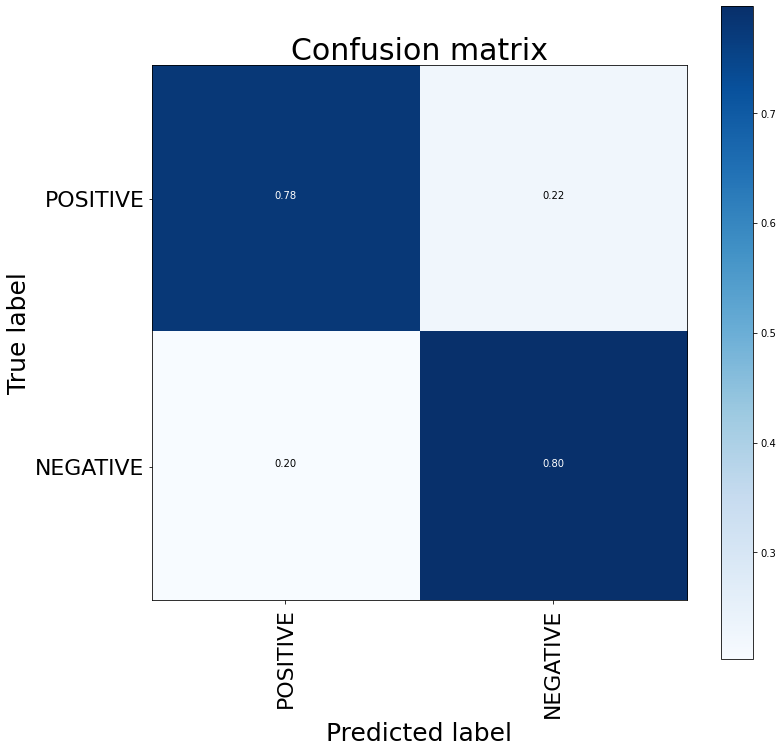

CPU times: user 1.19 s, sys: 20.3 ms, total: 1.21 s
Wall time: 1.2 s


In [ ]:
%%time

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_train.target.unique(), title="Confusion matrix")
plt.show()

**Step 6.4.6: Show Classification Report(Neural Network Model)**

In [ ]:
print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

    NEGATIVE       0.79      0.78      0.78    159494
    POSITIVE       0.78      0.80      0.79    160506

    accuracy                           0.79    320000
   macro avg       0.79      0.79      0.79    320000
weighted avg       0.79      0.79      0.79    320000



**Step 6.4.7: Show Accuracy Score(Neural Network Model)**

In [ ]:
accuracy_score(y_test_1d, y_pred_1d)

0.78741875

**Step 6.4.8: Save model**

In [ ]:
model.save(KERAS_MODEL)
w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)

2022-05-30 12:22:15,339 : INFO : Word2Vec lifecycle event {'fname_or_handle': 'model.w2v', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2022-05-30T12:22:15.339742', 'gensim': '4.2.0', 'python': '3.7.13 (default, Apr 24 2022, 01:04:09) \n[GCC 7.5.0]', 'platform': 'Linux-5.4.188+-x86_64-with-Ubuntu-18.04-bionic', 'event': 'saving'}
2022-05-30 12:22:15,342 : INFO : not storing attribute cum_table
2022-05-30 12:22:15,433 : INFO : saved model.w2v


Credit: https://www.kaggle.com/code/paoloripamonti/twitter-sentiment-analysis